### Hello everyone,

##### Welcome to this place,

In this simple notebook I'll show you a starter example for imbalanced dataset. In this example I'm going to analyze the famouse Credit Card Fraud Detection Dataset available on Kaggle ( https://www.kaggle.com/dalpozz/creditcardfraud ).

"The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions." 

The mean goal of this notebook is try to classify correctly frauds. Keep in mind that if you want to optimize AUC, or better, if you want to maximize the numbers of the rows you classify correctly, is mandatory note that the stupid algorithm that predict all the observation "not fraud" has an accuracy greater than 99%.

There are lots of way to manage this problem. In this notebook I'll show you some of them. 

## STRATEGY

In this notebook I'll use Logistic Regression.
    
    i) naive LogisticRegression (threshold 0.5)
    ii) LogisticRegression using threshold who maximize F1-score
    iii) LogisticRegression weighted
    iv) LogisticRegression affected by SMOTE upsampling 
    v) LogisticRegression affected by random downsampling
    
    
In this notebook I'm going to explain what I'll do step by step.

#### Hypothesis

I assume you are comfortable with LogisticRegression! If you are not you can find some intuitions
here: https://machinelearningmastery.com/logistic-regression-for-machine-learning/

Let's begin!

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import myfunc_viz as v
import myfunc as f

### PREPROCESSING

In [3]:
creditcard = pd.read_csv('creditcard.csv')
creditcard.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
print('There are {} records'.format(creditcard.shape[0]))
print('There are "just" {} frauds'.format(np.sum(creditcard['Class'].values)))

There are 284807 records
There are "just" 492 frauds


In [5]:
creditcard_other = creditcard[creditcard['Class'] == 0]
creditcard_fraud = creditcard[creditcard['Class'] == 1]

fraud_ratio = round(creditcard_fraud.shape[0]/creditcard_other.shape[0]*100,2)

print('That means the ratio of frauds is equal to: {}%'.format(fraud_ratio))

That means the ratio of frauds is equal to: 0.17%


In [6]:
name_X = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Amount','Time']

X_other = creditcard_other[name_X]
y_other = creditcard_other['Class']

X_fraud = creditcard_fraud[name_X]
y_fraud = creditcard_fraud['Class']

X_train_other, X_valid_other, y_train_other, y_valid_other = train_test_split(X_other, y_other, test_size=0.3, random_state=0)
X_train_fraud, X_valid_fraud, y_train_fraud, y_valid_fraud = train_test_split(X_fraud, y_fraud, test_size=0.3, random_state=0)

X_train_base = pd.concat([X_train_other,X_train_fraud],axis=0)
X_test = pd.concat([X_valid_other,X_valid_fraud],axis=0)
y_train_base = pd.concat([y_train_other,y_train_fraud],axis=0)
y_test = pd.concat([y_valid_other,y_valid_fraud],axis=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_base, y_train_base, test_size=0.3, random_state=0)

### PRELIMINARY INTUITIONS

The first step of this notebook is decide what we want to maximize.

Classifying by comparing the probability to 0.5 is inappropriate in case of imbalanced datasets. A better way is maximize a metric who takes into account the structure of the data as the F1-score. **If you want to maximize accuracy, the stupid model that always predicting zero could be your the optimal classifier!!!!!**

All of you known what is F1-score? (If you don't please read this page https://en.wikipedia.org/wiki/F1_score)

In a simplistic way is an average(defined in the previous link) between:

    1) Precision: is the fraction of retrieved documents that are relevant. Or in others terms the accuracy of the 0s.
    2) Recall: is the fraction of the relevant documents that are successfully retrieved. Or in others terms the accuracy of the 1s.
    

Note that if I decide to use the stupid algorithm that predict always 0 I got an accuracy above the 99% but my F1-score will be 0 because I'm totally missing all the 1s (RECALL = 0)

How can I maximize the F1-score? => CHOOSING THE RIGHT THRESHOLD! Choose the usual 0.5 is not the right strategy here.

Let's see with your eyes. 

##### i) Naive LogisticRegression

Confusion matrix in sample:

Confusion matrix, without normalization
[[59680    15]
 [   59    56]]


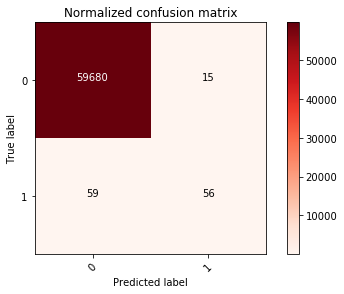

Precision: 0.79
Recall: 0.49
F1-Score: 0.6

Accuracy: 0.9988


Confusion matrix BLIND:

Confusion matrix, without normalization
[[85280    15]
 [   72    76]]


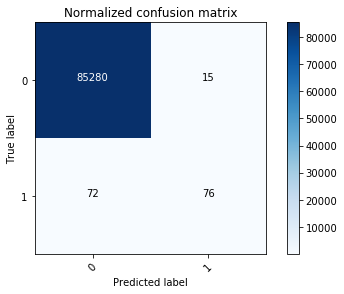

Precision: 0.84
Recall: 0.51
F1-Score: 0.64

Accuracy: 0.999




In [7]:
# This is the naive LogisticRegression that use 0.5 as threshold

model_logit = LogisticRegression(random_state=0).fit(X_train,y_train)

pred_logit_valid = model_logit.predict_proba(X_valid)[:,1]
pred_logit_test = model_logit.predict_proba(X_test)[:,1]

y_pred = np.array(pred_logit_test>0.5,dtype=int)
y_pred_valid = np.array(pred_logit_valid>0.5,dtype=int)
y_test = np.array(y_test, dtype=int)

print('Confusion matrix in sample:\n')
v.show_confusion_matrix(y_valid,y_pred_valid, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix')

print('Confusion matrix BLIND:\n')
v.show_confusion_matrix(y_test,y_pred, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix',col=True)

##### ii) LogisticRegression using threshold who maximize F1-score

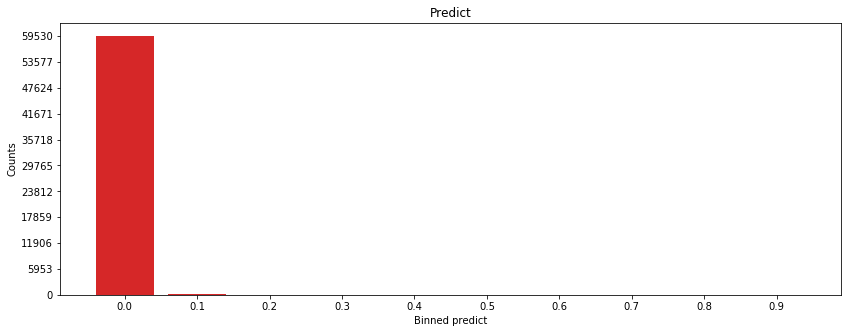

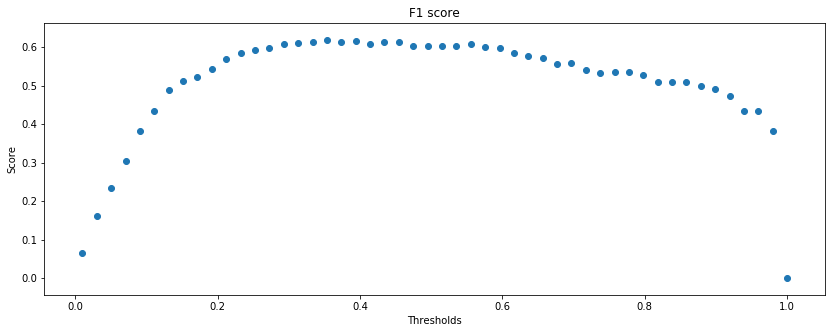

You should use 0.35 as threshold

Confusion matrix in sample:

Confusion matrix, without normalization
[[59674    21]
 [   54    61]]


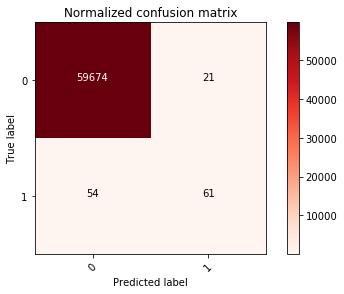

Precision: 0.74
Recall: 0.53
F1-Score: 0.62

Accuracy: 0.9987


Confusion matrix BLIND:

Confusion matrix, without normalization
[[85274    21]
 [   68    80]]


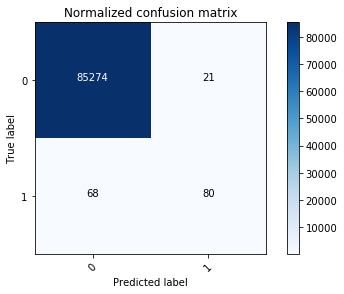

Precision: 0.79
Recall: 0.54
F1-Score: 0.64

Accuracy: 0.999




In [8]:
# this is the LogisticRegresison that takes into account the F1-score

model_logit = LogisticRegression(random_state=0).fit(X_train,y_train)

pred_logit_valid = model_logit.predict_proba(X_valid)[:,1]
pred_logit_test = model_logit.predict_proba(X_test)[:,1]

v.show_binned_predict_binaryclassification(y_valid,pred_logit_valid,10)

threshold = v.show_f1_score(y_valid,pred_logit_valid)

y_pred = np.array(pred_logit_test>threshold,dtype=int)
y_pred_valid = np.array(pred_logit_valid>threshold,dtype=int)
y_test = np.array(y_test, dtype=int)

print('Confusion matrix in sample:\n')
v.show_confusion_matrix(y_valid,y_pred_valid, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix')

print('Confusion matrix BLIND:\n')
v.show_confusion_matrix(y_test,y_pred, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix',col=True)

In [10]:
# model_logit = LogisticRegression(class_weight="balanced",random_state=0).fit(X_train,y_train)

# pred_logit_valid = model_logit.predict_proba(X_valid)[:,1]
# pred_logit_test = model_logit.predict_proba(X_test)[:,1]

# y_pred = np.array(pred_logit_test>0.5,dtype=int)
# y_pred_valid = np.array(pred_logit_valid>0.5,dtype=int)
# y_test = np.array(y_test, dtype=int)

# print('Confusion matrix in sample:\n')
# f.show_confusion_matrix(y_valid,y_pred_valid, classes=[0,1], normalize=False,
#                       title='Normalized confusion matrix')

# print('Confusion matrix BLIND:\n')
# f.show_confusion_matrix(y_test,y_pred, classes=[0,1], normalize=False,
#                       title='Normalized confusion matrix',col=True)

##### iii) LogisticRegression weighted

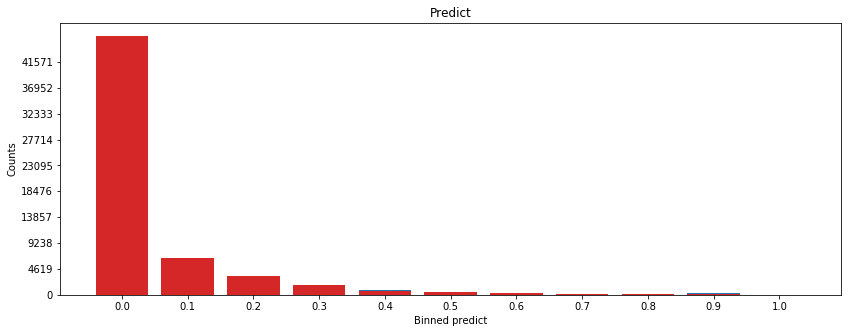

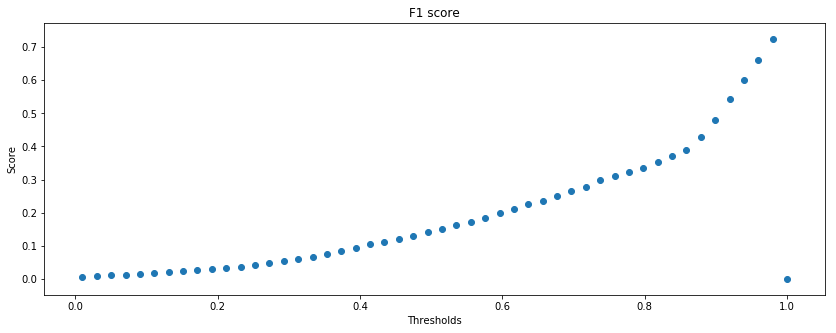

You should use 0.98 as threshold

Confusion matrix in sample:

Confusion matrix, without normalization
[[59641    54]
 [   19    96]]


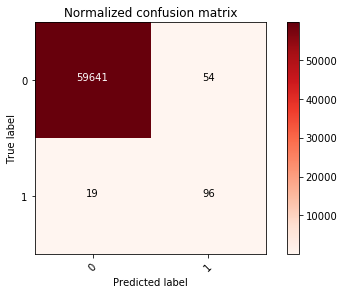

Precision: 0.64
Recall: 0.83
F1-Score: 0.72

Accuracy: 0.9988


Confusion matrix BLIND:

Confusion matrix, without normalization
[[85221    74]
 [   31   117]]


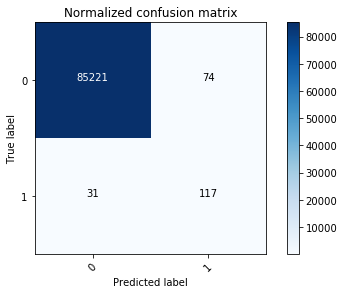

Precision: 0.61
Recall: 0.79
F1-Score: 0.69

Accuracy: 0.9988




In [9]:
model_logit = LogisticRegression(class_weight="balanced",random_state=0).fit(X_train,y_train)

pred_logit_valid = model_logit.predict_proba(X_valid)[:,1]
pred_logit_test = model_logit.predict_proba(X_test)[:,1]

v.show_binned_predict_binaryclassification(y_valid,pred_logit_valid,10)

threshold = v.show_f1_score(y_valid,pred_logit_valid)

y_pred = np.array(pred_logit_test>threshold,dtype=int)
y_pred_valid = np.array(pred_logit_valid>threshold,dtype=int)
y_test = np.array(y_test, dtype=int)

print('Confusion matrix in sample:\n')
v.show_confusion_matrix(y_valid,y_pred_valid, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix')

print('Confusion matrix BLIND:\n')
v.show_confusion_matrix(y_test,y_pred, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix',col=True)

##### Comments 

In this part we applied LogisticRegression using the option class_weight="balanced".  

** sklearn explanation: ** The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as ``n_samples / (n_classes * np.bincount(y))``.


# UPSAMPLING

One fake goal in imbalanced dataset problems is try to restore as much as possible the ideal proportion of 50%-50%. An easy strategy is try to weight differently the observation in the model as we tried before.

Other two possible strategy are: 
    
    1) downsampling: remove 0s "until" the ideal proportion
    2) upsampling: add "new" 1s "until" the ideal proportion
    
Until the ideal proportion could be to much, sometimes (in this case we have a really imbalanced dataset -- 0.17% vs 99.83%!) just a little help could be enough.

I do not like (this is a **my personal opinion**) change the data to much. I prefer leave the dataset as much as possible equal to the original dataset.

In this part I'll show you an easy technique of *upsampling*: SMOTE. You want details you can read this paper https://www.jair.org/media/953/live-953-2037-jair.pdf.

In few words SMOTE means generate synthetic new 1s near to the original. There are different variants of SMOTE: svm, borderlines. I'm using the easiest. 

N.B. I used my code for apply SMOTE. You can find an implementation of SMOTE using the library **imblearn** http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html#module-imblearn.over_sampling

    pip install imblearn
    from imblearn import over_sampling
   
In this case I'll try to upsample until the factor x10. From 0.17% => 1.7%

There are 199364 records in train: 0.17% are 1s and 99.83% are 0s


SMOTE applied...
There are 202403 records in train: 1.67% are 1s and 98.33% are 0s




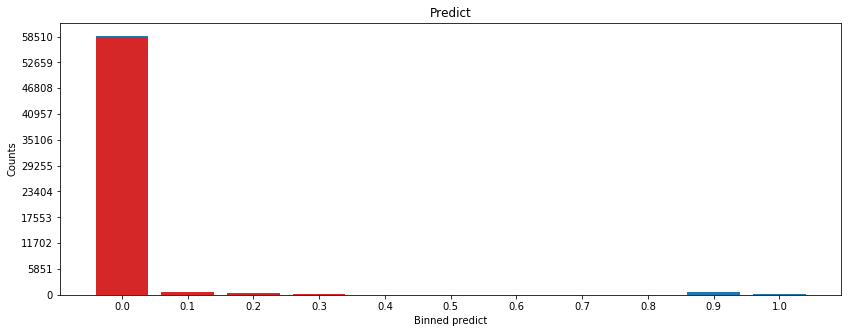

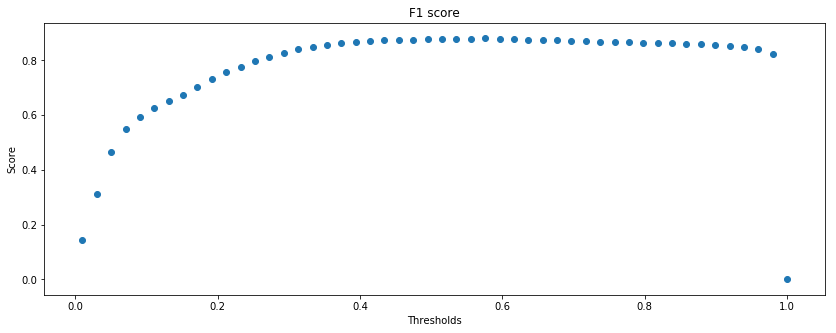

You should use 0.58 as threshold

Confusion matrix in sample:

Confusion matrix, without normalization
[[59586    40]
 [  203   892]]


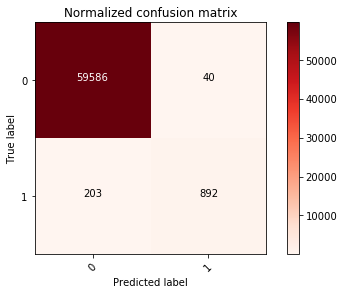

Precision: 0.96
Recall: 0.81
F1-Score: 0.88

Accuracy: 0.996


Confusion matrix BLIND:

Confusion matrix, without normalization
[[85252    43]
 [   34   114]]


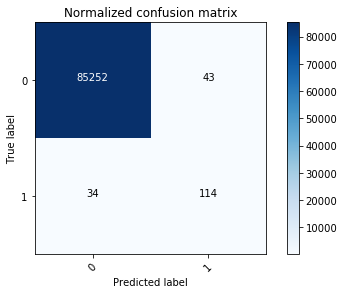

Precision: 0.73
Recall: 0.77
F1-Score: 0.75

Accuracy: 0.9991


Wall time: 3.49 s


In [10]:
%%time

threshold_rebalancing_of_1s = 0.017

n_tot = X_train_base.shape[0]
n_1s = np.sum(y_train_base)
perc_1s = round(n_1s/n_tot*100,2)

print('There are {} records in train: {}% are 1s and {}% are 0s\n\n'.format(n_tot
                                                                      ,perc_1s
                                                                      ,100-perc_1s
                                                                      ))


X_res,y_res = f.binary_up_SMOTE(X_train_base.values,y_train_base.values,threshold_rebalancing_of_1s, random_state=0)

X_train_res, X_valid_res, y_train_res, y_valid_res = train_test_split(X_res, y_res, test_size=0.3, random_state=0)

model_logit_smote = LogisticRegression(random_state=0).fit(X_train_res,y_train_res)

pred_logit_valid = model_logit_smote.predict_proba(X_valid_res)[:,1]
pred_logit_test = model_logit_smote.predict_proba(X_test)[:,1]

v.show_binned_predict_binaryclassification(y_valid_res,pred_logit_valid,10)

threshold = v.show_f1_score(y_valid_res,pred_logit_valid)

y_pred_smote = np.array(pred_logit_test>threshold,dtype=int)
y_pred_valid_smote = np.array(pred_logit_valid>threshold,dtype=int)
y_test_res = np.array(y_test, dtype=int)

print('Confusion matrix in sample:\n')
v.show_confusion_matrix(y_valid_res,y_pred_valid_smote, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix')

print('Confusion matrix BLIND:\n')
v.show_confusion_matrix(y_test,y_pred_smote, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix',col=True)

# DOWNSAMPLING

In this part I'll show you the easiest strategy of downsamplig => RANDOM

In this case I decided to cut the half of the 0s. This means we'll achieve a value less than 0.35% of 1s, *awkward!!*

There are 199364 records in train: 0.17% are 1s and 99.83% are 0s


Random downsampling applied...
There are 99854 records in train: 0.34% are 1s and 99.66% are 0s




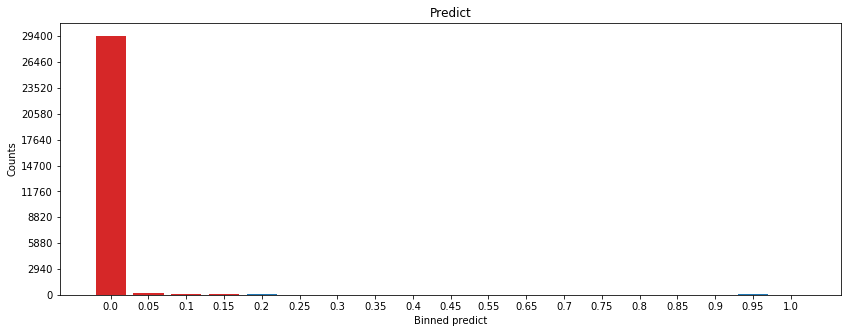

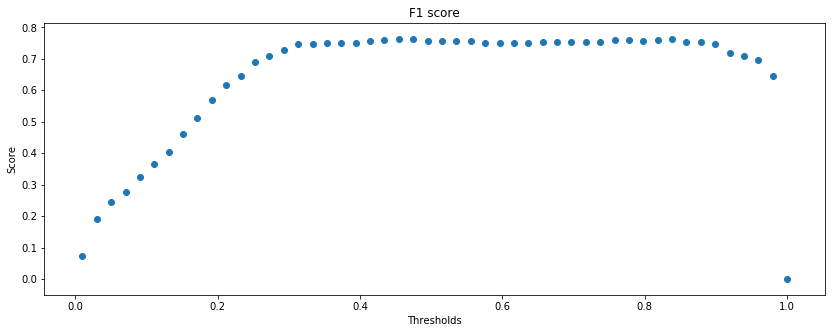

You should use 0.45 as threshold

Confusion matrix in sample:

Confusion matrix, without normalization
[[29841    12]
 [   33    71]]


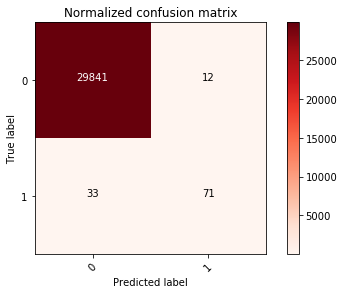

Precision: 0.86
Recall: 0.68
F1-Score: 0.76

Accuracy: 0.9985


Confusion matrix BLIND:

Confusion matrix, without normalization
[[85265    30]
 [   40   108]]


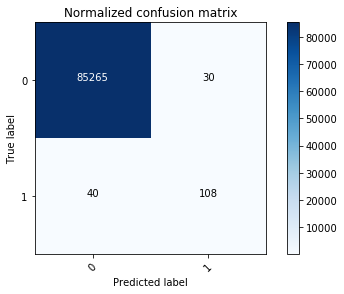

Precision: 0.78
Recall: 0.73
F1-Score: 0.76

Accuracy: 0.9992




In [11]:
threshold_downsampling_of_0s = 0.5

n_tot = X_train_base.shape[0]
n_1s = np.sum(y_train_base)
perc_1s = round(n_1s/n_tot*100,2)

print('There are {} records in train: {}% are 1s and {}% are 0s\n\n'.format(n_tot
                                                                      ,perc_1s
                                                                      ,100-perc_1s
                                                                      ))

X_undersampled, y_undersampled = f.binary_down_RANDOM(X_train_base.values,
                                                      y_train_base.values,
                                                      threshold_downsampling_of_0s
                                                      )

X_train, X_valid, y_train, y_valid = train_test_split(X_undersampled, y_undersampled, test_size=0.3, random_state=0)

model_logit = LogisticRegression(random_state=0).fit(X_train,y_train)

pred_logit_valid = model_logit.predict_proba(X_valid)[:,1]
pred_logit_test = model_logit.predict_proba(X_test)[:,1]

v.show_binned_predict_binaryclassification(y_valid,pred_logit_valid,20)

threshold = v.show_f1_score(y_valid,pred_logit_valid)

y_pred = np.array(pred_logit_test>threshold,dtype=int)
y_pred_valid = np.array(pred_logit_valid>threshold,dtype=int)
y_test = np.array(y_test, dtype=int)

print('Confusion matrix in sample:\n')
v.show_confusion_matrix(y_valid,y_pred_valid, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix')

print('Confusion matrix BLIND:\n')
v.show_confusion_matrix(y_test,y_pred, classes=[0,1], normalize=False,
                      title='Normalized confusion matrix',col=True)

## CONCLUSION

In think that for this notebook is enough. 

A little summary of we've done:

    i) naive LogisticRegression (threshold 0.5)
    ii) LogisticRegression using threshold who maximize F1-score
    iii) LogisticRegression weighted
    iv) LogisticRegression affected by SMOTE upsampling 
    v) LogisticRegression affected by random downsampling
    
I have many conclusions:

In this dataset and using LogisticRegression as algorithm **in my opinion** the winner is *v)*. We should be able to get better decision if we had the structure of the cost of FN and FP. Note that the naive LogisticRegression was the model who found the lower amount of FP. The knowledge of the cost structure in this case is crucial for a good decision. Anyway, using LogisticRegression, the model who maximize the F1-score is the _v)_.

As I previously said this notebook is just a starter for imbalanced data. There are many others possible techniques to test and may others metrics.

The goal of this notebook was just show technique for imbalanced datasets. I did not preprocessing, I did not cross-validate, but you should. 

If you enjoy this first notebook I promise I'll show you in the future others ways to manage imbalanced datasets trying also others models and strategies. So, if you liked it: comment, share, like, text me, everything and...**stay tuned!**

#### Let be free to contact my for new points of view as well as advice.

#### I hope you appreciate this notebook,
#### See you around,
#### Federico